Open input data:

In [2]:
from PIL import Image
import pickle

path = '/Users/manu/boulot/unit_solutions/data/toy_data/are_detections_on_same_line/'

img_pil_focus = Image.open(path + "img_pil_focus.jpg")

with open(path + "scontent.pkl", "rb") as f:
    scontent = pickle.load(f)

with open(path + "boxes.pkl", "rb") as f:
    boxes = pickle.load(f)

Define function:

In [14]:
import numpy as np

def distance_btw_point_and_line(pos_point, pos_line_1, pos_line_2):
    pos_line_1 = np.array(pos_line_1)
    pos_line_2 = np.array(pos_line_2)
    pos_point = np.array(pos_point)

    return np.abs(np.cross(pos_line_2 - pos_line_1, pos_point - pos_line_1) / np.linalg.norm(pos_line_2 - pos_line_1))

print(distance_btw_point_and_line((10, 0), (0, 0), (0, 20))) # output should be 10
#print(distance_btw_point_and_line((10, 14), (0, 0), (20, 20))) # reproduce example from https://bobbyhadz.com/blog/numpy-calculate-distance-between-point-and-line


10.0
2.82842712474619


/var/folders/yp/5_5sqn5n3sl1tg47qtrnc12h0000gn/T/ipykernel_40842/1121532770.py:8: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(pos_line_2 - pos_line_1, pos_point - pos_line_1) / np.linalg.norm(pos_line_2 - pos_line_1))


Use function to determine which line a symbol corresponds to:

In [15]:
scontent

[{'destination': ' Forsterhuus',
  'duration': ' 1h 30min',
  'pos_dest': (466.2275390625, 135.0),
  'pos_dura': (515.5849609375, 104.0)},
 {'destination': 'Stein am Rhein',
  'duration': ' 2h 20min',
  'pos_dest': (364.8447265625, 173.0),
  'pos_dura': (510.2490234375, 146.0)}]

In [21]:
def get_lines_for_boxes(boxes, scontent):
    '''
    For each box in boxes, get the closest line.
    :param boxes: (ultralytics.engine.results.Boxes) detected boxes and associated classes
    :param scontent: (list of dict) sign content
    :return: (list of int) list containing closest line index for each box. The list idx corresponds to box idx
    '''
    idx_closest_line_per_box = []
    for box in boxes:
        x_box, y_box, _, _ = box.xywh[0]
        dist_list = []
        for lcontent in scontent: # for each line in sign
            dist = distance_btw_point_and_line((x_box, y_box), lcontent['pos_dest'], lcontent['pos_dura'])
            dist_list.append(dist)

        idx_closest_line = int(np.argmin(dist_list))
        idx_closest_line_per_box.append(idx_closest_line)
    return idx_closest_line_per_box


We want to add a key to lcontent: lcontent['symbols'] = [class_lbl_1, class_lbl_2, ...]

In [34]:
for idx_line, lcontent in enumerate(scontent): # for each line in sign
    idx_closest_line_per_box = get_lines_for_boxes(boxes=boxes, scontent=scontent)
    #idx_boxes = find(idx_closest_line_per_box==idx_line)
    idx_boxes = np.nonzero(np.array(idx_closest_line_per_box)==idx_line)

    class_lbl_list = None  # default value
    if len(idx_boxes[0]) > 0: # if for this line corresponding boxes have been found
        class_lbl_list = []
        for idx_box in idx_boxes:
            box = boxes[idx_box]
            class_lbl_list.append(int(box.cls[0]))

    lcontent['symbols'] = class_lbl_list
    scontent[idx_line] = lcontent

/var/folders/yp/5_5sqn5n3sl1tg47qtrnc12h0000gn/T/ipykernel_40842/1121532770.py:8: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(pos_line_2 - pos_line_1, pos_point - pos_line_1) / np.linalg.norm(pos_line_2 - pos_line_1))


Verification: plot line for each box

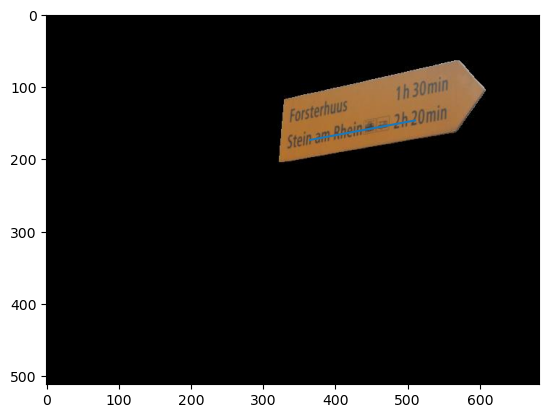

In [36]:
import matplotlib.pyplot as plt

img_np_focus = np.asarray(img_pil_focus)

fig, ax = plt.subplots(1,1)
ax.imshow(img_np_focus)

for lcontent in scontent:
    if lcontent['symbols'] is not None:
        ax.plot((lcontent['pos_dest'][0], lcontent['pos_dura'][0]), (lcontent['pos_dest'][1], lcontent['pos_dura'][1]))